In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

### Data Cleaning

In [2]:
df = pd.read_csv('CPITimeSeries.csv',sep=',',header=0)

C:\Users\esrpi\AppData\Local\Temp\ipykernel_14860\2354858438.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,25

In [3]:
df = df.drop(df[df["Indicator Code"] != "PCPI_IX"].index)
df = df.drop(df[df["Attribute"] != "Value"].index)
df = df.drop(['Indicator Name','Common Reference Period','Unnamed: 878'],axis=1)
df = df.drop(columns = ["Indicator Code","Attribute"])
df = df.reset_index(drop=True)

years_to_drop = []
for y in range(40):
    for m in range(12):
        years_to_drop.append(f'19{50+y}M{m+1}')

df = df.drop(years_to_drop,axis=1)
df.head()

,Country Name,Country Code,1990M1,1990M2,1990M3,1990M4,1990M5,1990M6,1990M7,1990M8,...,2021M11,2021M12,2022M1,2022M2,2022M3,2022M4,2022M5,2022M6,2022M7,2022M8
0,Brazil,223,0.005410857,0.009508499,0.01734255,0.02003411,0.0215547,0.02408738,0.02719947,0.03070276,...,6075.69,6120.04,6153.09,6215.24,6315.93,6382.88,6412.88,6455.85,6411.95,NaN
1,France,132,66.42,66.56,66.72,67.09,67.19,67.18,67.2,67.64,...,107.64,107.85,108.12,108.94,110.49,110.97,111.72,112.55,112.87,113.29
2,Bulgaria,918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7659.2699399122,7728.99879117314,7841.08640403034,7954.55523691129,8131.17796924526,8331.52722236692,8432.65279081599,8506.69398844988,8601.91208943529,8702.17132815588
3,Honduras,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,365,368.5,373,374.3,377.8,384.2,387.6,392.7,396.2,396.1
4,Colombia,233,5.967753,6.191108,6.372583,6.547079,6.679696,6.805333,6.89607,7.007748,...,110.6031,111.4066,113.2623,115.1129,116.2593,117.7089,118.7032,119.3053,120.2736,121.5025


In [ ]:
# find countries whose alias are obscured
[s for s in df["Country Name"].to_list() if "Ukraine" in s]

Text(0.5, 0, 'Time (Year-Month)')

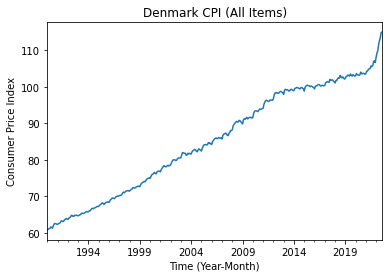

In [4]:
index = pd.period_range('1990-01','2022-08',freq='M')

country_name = 'Denmark'
vals = df[df['Country Name'] == country_name].drop(["Country Name","Country Code"],axis=1).to_numpy()[0]

ts = pd.Series(data=vals,index=index,dtype=np.float64,name=country_name)

fig = plt.figure()
ax = ts.plot()
ax.set_title('Denmark CPI (All Items)')
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

The TS has a clear trend and seems to present a yearly seasonality

#### TS splitting

Text(0.5, 0, 'Time (Year-Month)')

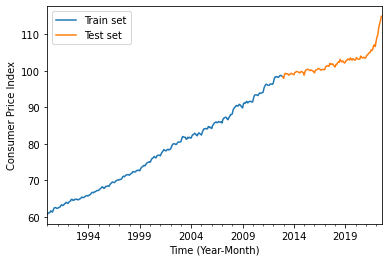

In [6]:
test_size_prctg = 30
test_size = int(len(ts)*test_size_prctg/100) # as in percentage
ts_train = ts[:-test_size]
ts_test = ts[-test_size:]

ts_train.name = "Train set"
ts_test.name = "Test set"

fig = plt.figure()
ax = ts_train.plot(legend=True)
ts_test.plot(ax=ax,legend=True)
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

#plt.savefig('figs/cpi.pdf')
#plt.close()

#### Basic description tecnhiques & transformations

##### Polynomial Fitting

MSE (Linear):0.00013848870193736056
MSE (Quadratic):4.340591418463259e-05
MAE (Linear):0.009590638344757416
MAE (Quadratic):0.005350947038112976


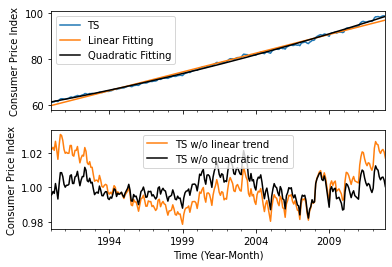

In [7]:
ts_train.name = 'TS' # reset name for plotting purposes

n = np.array(range(len(ts_train)))

coefs = np.polyfit(n,ts_train.values,1)
vals = np.polyval(coefs,n)
lin_ts=pd.Series(vals,index=ts_train.index,name="Linear Fitting")

coefs = np.polyfit(n,ts_train.values,2)
vals = np.polyval(coefs,n)
quad_ts=pd.Series(vals,index=ts_train.index,name="Quadratic Fitting")

fig, (ax1, ax2) = plt.subplots(2,sharex=True)

ts_train.plot(ax=ax1,legend=True)
lin_ts.plot(ax=ax1,legend=True)
quad_ts.plot(ax=ax1,legend=True, color='k')
ax1.set_ylabel('Consumer Price Index')
ax1.set_xlabel('Time (Year-Month)')

# removing linear trend
nolin_ts = ts_train/lin_ts
nolin_ts.name = "TS w/o linear trend"
ax2 = nolin_ts.plot(legend=True,color='tab:orange')
ax2.set_ylabel('Consumer Price Index')
ax2.set_xlabel('Time (Year-Month)')

# removing quadratic trend
#plt.figure()
noquad_ts = ts_train/quad_ts
noquad_ts.name = "TS w/o quadratic trend"
noquad_ts.plot(ax=ax2,legend=True,color='k')
#ax2.set_ylabel('Consumer Price Index')
#ax2.set_xlabel('Time (Year-Month)')

#plt.savefig('figs/diff.pdf')
print(f'MSE (Linear):{np.mean((nolin_ts - 1)**2)}')
print(f'MSE (Quadratic):{np.mean((noquad_ts - 1)**2)}')
print(f'MAE (Linear):{np.mean(np.abs(nolin_ts - 1))}')
print(f'MAE (Quadratic):{np.mean(np.abs(noquad_ts - 1))}')

Concerning the independence of the seasonality and erratic components from the trend, a multiplicative mode is better suited. The quadratic model seems to model better the increasing trend, as the peaks circa 1900-1994 and 2002-2004 are not well captured by the linear trend.

##### Moving-Average Local Smoothing

C:\Users\esrpi\AppData\Local\Temp\ipykernel_14860\3680167205.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TSeriesAug=TSeries.append(np.flip(TSeries[-lag:]))
C:\Users\esrpi\AppData\Local\Temp\ipykernel_14860\3680167205.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TSeriesAug=np.flip(TSeries[0:lag]).append(TSeriesAug)


MSE: 1.391685152833667e-05
MEA: 0.0030121215549487926


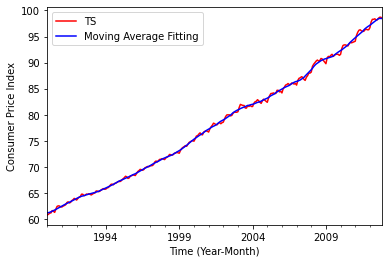

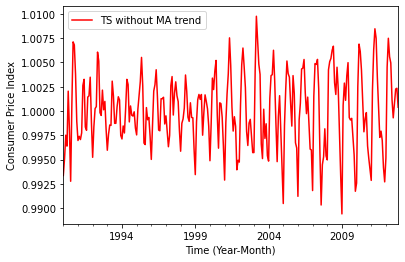

In [9]:
def maSmooth(TSeries,omega,data_aug=False):
    M=omega.shape[0]
    lag=int(np.floor((M-1)/2))
    
    if data_aug: #If smooted TS should have the same number of samples
        TSeriesAug=TSeries.append(np.flip(TSeries[-lag:]))
        TSeriesAug=np.flip(TSeries[0:lag]).append(TSeriesAug)
        
    else:
        TSeriesAug=TSeries
        
    nf=range(lag,TSeriesAug.size-lag)
    xf=np.zeros(TSeriesAug.size-2*(lag)).astype('float')
    for n in nf:
        xf[n-lag]=(1/float(sum(omega)))*np.sum(np.multiply(TSeriesAug[n-lag:n+lag+1],omega))
    xf=pd.Series(data=xf, index=TSeriesAug.index[lag:TSeriesAug.size-lag],name="Moving Average Fitting")
    
    return xf

M=13
omega=np.ones(M)*(1/float(M))
ma_smooth=maSmooth(ts_train,omega,data_aug=True)

#with plt.style.context('science'):

plt.figure()
ax=ts_train.plot(legend=True,color='r')
ma_smooth.plot(ax=ax,legend=True,color='b')
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

plt.figure()
nomasmooth_ts = ts_train/ma_smooth
nomasmooth_ts.name = "TS without MA trend"
ax=nomasmooth_ts.plot(legend=True,color='r')
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')
 

print(f'MSE: {np.mean((nomasmooth_ts - 1)**2)}')
print(f'MEA: {np.mean(np.abs(nomasmooth_ts - 1))}')

The figures show that the local smoothing approach is actually better at removing the trend than the polynomial approaches

##### LOcally WEighted Scatter plot Smooth (LOWESS)

MSE:9.432524264714171e-06
MEA: 0.002425595527033486


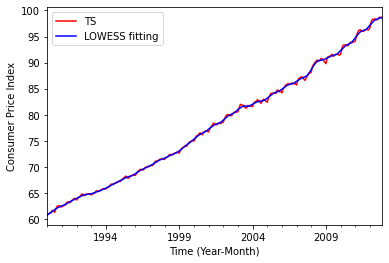

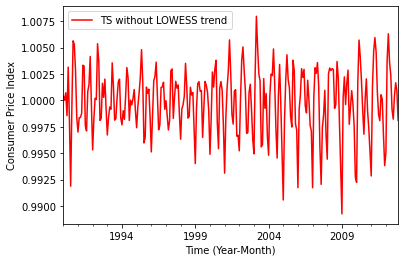

In [10]:
import statsmodels.api as sm
from scipy.optimize import curve_fit

def flin(x,a,b):
    return a*x+b

def xWeights(x,xi,span):
    wi=(1-abs((x-xi)/float(span))**3)**3
    #plt.figure()
    #plt.plot(wi)
    return wi

def yWeights(ri,MAD):
    if np.abs(ri)<6*MAD:
        return (1-((ri/(6*MAD))**2))**2
    else:
        return 0


def loessPass(TSeries,TSeriesE=pd.Series(np.array([])),span=5,timePass=True):
    lag=int((span-1)/2)
    xf=np.zeros(TSeries.size).astype('float')
    for k in range(TSeries.size):
        if k<=lag:
            win=TSeries[0:span]
            if not timePass:
                winE=TSeriesE[0:span]
            xvs=np.array(range(span))
            #print "No inicio"
        elif k>TSeries.size-lag:
            #print "No fim"
            win=TSeries[TSeries.size-span:TSeries.size]
            if not timePass:
                winE=TSeriesE[TSeriesE.size-span:TSeriesE.size]
            xvs=np.array(range(TSeries.size-span,TSeries.size))
        else:
            #print "No meio"
            win=TSeries[k-lag-1:k+lag]
            if not timePass:
                winE=TSeriesE[k-lag-1:k+lag]
            xvs=np.array(range(k-lag,k+lag+1))

        ws=np.zeros(span).astype('float')
            
        if not timePass:
            res=np.array(win-winE)
            #res=res.as_matrix()
            MAD=np.median(np.abs(res))
            
        for xw in range(len(xvs)):
            if timePass:
                ws[xw]=xWeights(k,xvs[xw],np.max((np.abs(k-xvs[0]),np.abs(k-xvs[-1]))))
            else:
                ws[xw]=yWeights(res[xw],MAD)
            #print np.max((np.abs(k-xvs[0]),np.abs(k-xvs[-1])))
        exog = sm.add_constant(xvs)
        
        
        mod_wls = sm.WLS(win, exog, weights=ws)
        res_wls = mod_wls.fit()
        
        xf[k]=res_wls.params[1]*k+res_wls.params[0]
    return xf

def lowess(TSeries,span=5,ftype='linear'):
    
    xf=loessPass(TSeries,span=span,timePass=True)
    xf=loessPass(TSeries,TSeriesE=pd.Series(data=xf, index=TSeries.index),span=span,timePass=False)
    xf=pd.Series(data=xf, index=TSeries.index,name="Lowess Fitting")
    return xf

from statsmodels.nonparametric.smoothers_lowess import lowess as lw

lowess_smooth = pd.Series(
    data=lw(ts_train.values, np.arange(len(ts_train.index)), frac=(13.1/275), it=1)[:,1], # 13,1 because lowess uses a fraction of the data as time window, and f=13,1/275 assures that f*275~13 instead of ~12 
    index=ts_train.index,
    name='LOWESS fitting')
    
#lowess_smooth=lowess(ts_train,span=13)

#with plt.style.context('science'):

plt.figure()
ax=ts_train.plot(legend=True,color='r')
lowess_smooth.plot(ax=ax,legend=True,color='b')
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

plt.figure()
nolowesssmooth_ts = ts_train/lowess_smooth
nolowesssmooth_ts.name = "TS without LOWESS trend"
ax=nolowesssmooth_ts.plot(legend=True,color='r')
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

# take the MSE
print(f'MSE:{np.mean((nolowesssmooth_ts - 1)**2)}')
print(f'MEA: {np.mean(np.abs(nolowesssmooth_ts - 1))}')

The LOWESS approach seems to equally model the trend. However the $MSE$ taken for all approaches indicate that the MA approach is better at modelling the trend.

Text(0.5, 0, 'Time (Year-Month)')

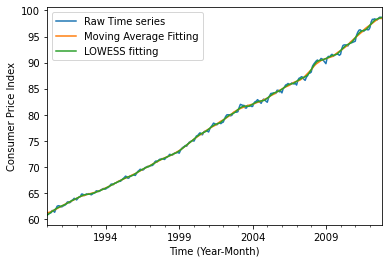

In [16]:
ts_train.name = "Raw Time series"

#with plt.style.context(['science','ieee']):

plt.figure()
ax=ts_train.plot(legend=True)
ma_smooth.plot(ax=ax, legend=True)
lowess_smooth.plot(ax=ax,legend=True)
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

#plt.savefig('figs/trend.pdf')

##### Seasonality Assessment
First, lets seasonality by fourier transforms, i.e., removing cycles

Text(0.5, 0, 'Time (Year-Month)')

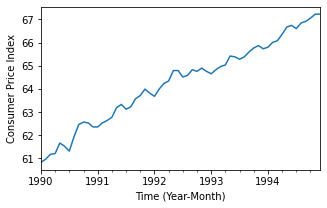

In [17]:
plt.figure(figsize=(5,3))
ax = ts_train[0:12*5].plot()
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

It seems that there is a seasonal pattern that repeats every 12 months and an internal pattern every 6 months

Text(0, 0.5, 'Normalized Power Spectrum (A.U:)')

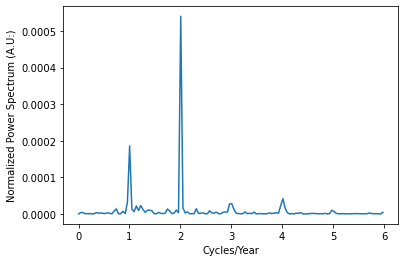

In [18]:
def describe_frequencies(ts, sample_frequency = 12,):
    dft = (np.abs(np.fft.rfft(ts-ts.mean()))**2/ts.size)
    f = np.fft.rfftfreq(ts.size, d=1/sample_frequency)
    return dft, f

dft, f = describe_frequencies(nolowesssmooth_ts)#nomasmooth_ts)

plt.figure()
plt.plot(f,dft)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U:)")

TS appears a little "polluted" with noise, so lets get rid of frequencies below 0.0001

Text(0, 0.5, 'Normalized Power Spectrum (A.U:)')

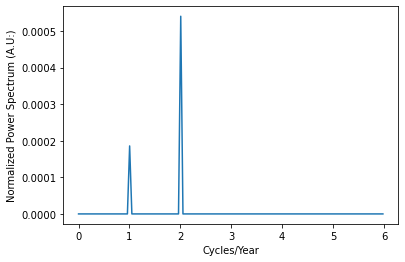

In [19]:
def clean_ft(ft):
    return (ft>0.0001)*ft

plt.figure()
plt.plot(f,clean_ft(dft))
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U:)")

It seams as tho the most important component is the one located at 2 cycle/year, so the most important seasonality pattern occurs each 6 months. With this in mind, there is also a clear pattern every year, so we will remove both

Text(0.5, 0, 'Time (Year-Month)')

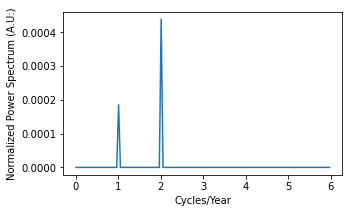

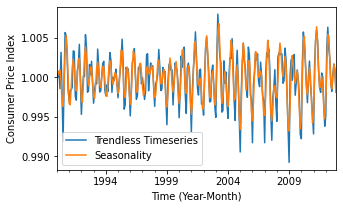

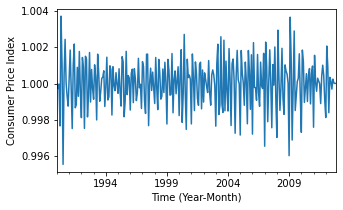

In [20]:
import scipy.signal as scs

#nomasmooth_ts.name = 'Trendless TS'
nolowesssmooth_ts.name = 'Trendless Timeseries'

sos = scs.butter(N=5,fs=12,Wn=[2.4],output='sos')
seasonal = scs.sosfiltfilt(sos,nolowesssmooth_ts)

dft, f = describe_frequencies(seasonal)
plt.figure(figsize=(5,3))
plt.plot(f,clean_ft(dft))
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U:)")

# Plot seasonal component
ts_seasonal = pd.Series(seasonal,ts_train.index,name="Seasonality")

plt.figure(figsize=(5,3))
ax = nolowesssmooth_ts.plot(legend=True)
ts_seasonal.plot(ax=ax,legend=True)
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

# Remove seasonal component
erratic_ts = nolowesssmooth_ts/ts_seasonal
erratic_ts.name="Erratic Component"

plt.figure(figsize=(5,3))
ax = erratic_ts.plot()
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

Text(0, 0.5, 'Normalized Power Spectrum (A.U:)')

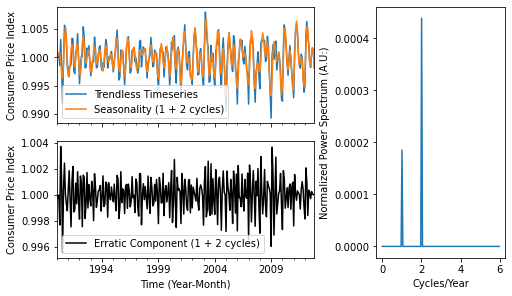

In [21]:
from matplotlib.gridspec import GridSpec

ts_seasonal = pd.Series(seasonal,ts_train.index,name="Seasonality (1 + 2 cycles)")

#with plt.style.context(['science','ieee']):

fig = plt.figure(constrained_layout=True, figsize=(7,4))
gs = GridSpec(2,3, figure=fig)
ax1 = fig.add_subplot(gs[0,0:-1])

nolowesssmooth_ts.plot(ax=ax1,legend=True)
ts_seasonal.plot(ax=ax1,legend=True)
ax1.set_ylabel('Consumer Price Index')
ax1.set_xlabel('Time (Year-Month)')

erratic = nolowesssmooth_ts/ts_seasonal
erratic.name="Erratic Component (1 + 2 cycles)"

ax2 = fig.add_subplot(gs[1,0:-1], sharex=ax1)

erratic.plot(ax=ax2,legend=True, color='k')
ax2.set_ylabel('Consumer Price Index')
ax2.set_xlabel('Time (Year-Month)')

ax3 = fig.add_subplot(gs[:,2])

dft, f = describe_frequencies(seasonal)
ax3.plot(f,clean_ft(dft))
ax3.set_xlabel("Cycles/Year")
ax3.set_ylabel("Normalized Power Spectrum (A.U:)")

#plt.savefig('figs/season.pdf')

**Epoch Averaging** can provide a closer look.

Text(0.5, 0, 'Time (Year-Month)')

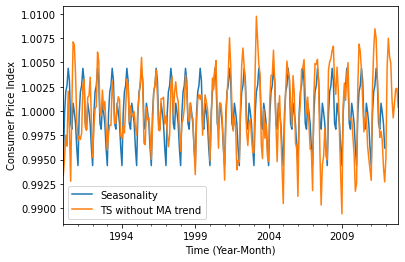

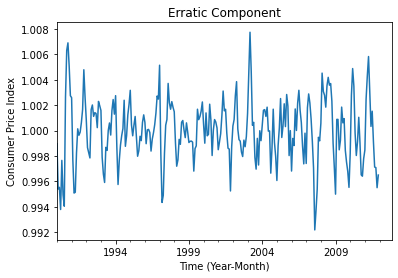

In [22]:
S = 12
N = nomasmooth_ts[:-11].size
C = int(np.floor(N/S))
ac = nomasmooth_ts[:-11].to_numpy().reshape((C,S))

seasonal = np.tile(np.mean(ac,axis=0),(C,))
notrend_ts_temp = nomasmooth_ts[:C*S]
ts_seasonal = pd.Series(seasonal,notrend_ts_temp.index,name="Seasonality")

plt.figure()
ax = ts_seasonal.plot(legend=True)
nomasmooth_ts.plot(ax=ax,legend=True)
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

# Remove seasonal component
notrend_noseasonal_trend = nomasmooth_ts/ts_seasonal
notrend_noseasonal_trend.name="Erratic Component"

plt.figure()
ax = notrend_noseasonal_trend.plot()
ax.set_title("Erratic Component")
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

##### Differencing
A differencing approach can provide further insights

Text(0.5, 0, 'Time (Year-Month)')

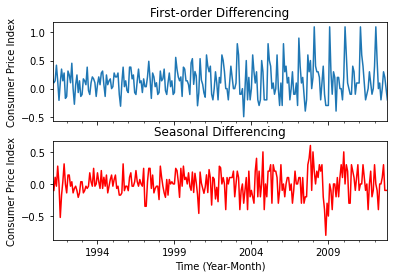

In [24]:
#with plt.style.context(['science','ieee']):

#fig, (ax1, ax2) = plt.subplots(2, figsize=(3.3,3), sharex=True)
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

# First-order differencing
ts_diff_1 = ts_train.diff().dropna()
ts_diff_1.name="First-order Differencing"
ax1.set_title(ts_diff_1.name)
ts_diff_1.plot(ax=ax1)
ax1.set_ylabel('Consumer Price Index')

# Seasonal differencing
ts_diff_2 = ts_diff_1.diff(12).dropna()
ts_diff_2.name="Seasonal Differencing"
ax2.set_title(ts_diff_2.name)
ts_diff_2.plot(ax=ax2, color='r')
ax2.set_ylabel('Consumer Price Index')
ax2.set_xlabel('Time (Year-Month)')

#plt.savefig('figs/differencing.pdf')

##### AutoCorrelation Analysis

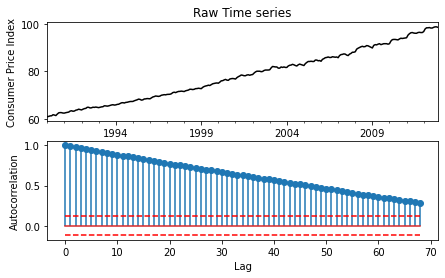

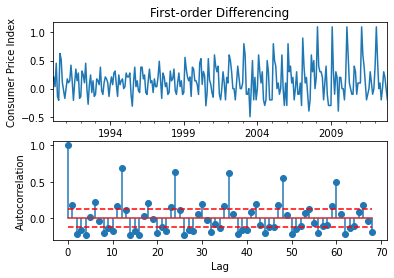

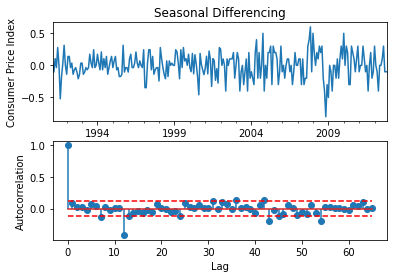

In [25]:
import scipy.stats as spyst


def autocov(timeserie,T=0):
    N=timeserie.size
    mu=timeserie.mean()
    covCoef=0
    for n in range(0,N-T-1):
        covCoef=covCoef+(timeserie[n]-mu)*(timeserie[n+T]-mu)
    return covCoef/float(np.abs(N))
        

def autocoef(timeserie,T=0):
    return autocov(timeserie,T)/autocov(timeserie)

def correlogram(timeserie,maxT,twoside=False):
    N=timeserie.size
    if twoside:
        corrl=np.zeros(2*maxT+1)
        ix=np.array(range(maxT+1))
        ix=np.concatenate((-np.flip(ix[1:]),ix),axis=0)
    else:
        corrl=np.zeros(maxT+1)  
        ix=np.array(range(maxT+1))
    
    for i in range(maxT+1):
        if twoside:
            corrl[i+maxT]=autocoef(timeserie,i);
            if i>0:
                corrl[maxT-i]=corrl[i+maxT]
        else:
            corrl[i]=autocoef(timeserie,i);
    d = {'ACS':corrl, 'upsig':np.ones(maxT+1)*(1.96/np.sqrt(N)),'dnsig':-np.ones(maxT+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl

def meanvarWtime(timeseries,W=6):
    Nwin=int(np.floor(timeseries.size/W))
    vals=timeseries.to_numpy()
    vals=vals[0:int(Nwin*W)]
    mvals=vals.reshape((Nwin,W))
    return {'mu':np.mean(mvals,axis=1),'var':np.var(mvals,axis=1)}

def plot_acs(ts, ax, name):
    N = ts.size
    corr = correlogram(ts, maxT=int(N/4))
    corr.name = name
    ax.stem(corr.index,corr['ACS'])
    ax.plot(corr.index,corr['upsig'], linestyle='--', color='r', linewidth=1.5)
    ax.plot(corr.index,corr['dnsig'], linestyle='--', color='r', linewidth=1.5)
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")

# Plot ACS for Raw TS

#with plt.style.context(['science','ieee']):

    # plt.rcParams.update({
    #     'lines.markersize': 3
    # })

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,4))

ts_train.plot(ax=ax1, color='k')
ax1.set_title(ts_train.name)
ax1.set_ylabel('Consumer Price Index')
ax1.set_xlabel('Time (Year-Month)')

plot_acs(ts_train,ax2,'ACS')

#plt.savefig('figs/acs_raw.pdf')

# Plot ACS for 1st-order diff

fig, (ax1, ax2) = plt.subplots(2,1)

ts_diff_1.plot(ax=ax1)
ax1.set_title(ts_diff_1.name)
ax1.set_xlabel('Time (Year-Month)')
ax1.set_ylabel('Consumer Price Index')

plot_acs(ts_diff_1,ax2,'ACS')

#plt.savefig('figs/acs_first.pdf')

fig, (ax1, ax2) = plt.subplots(2,1)

ts_diff_2.plot(ax=ax1)
ax1.set_title(ts_diff_2.name)
ax1.set_ylabel('Consumer Price Index')
ax1.set_xlabel('Time (Year-Month)')

plot_acs(ts_diff_2,ax2,'ACS')
#plt.savefig('figs/acs_seasonal.pdf')

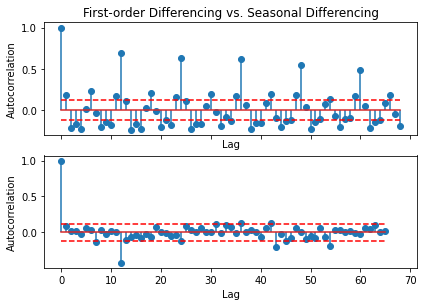

In [26]:
# Plot ACS for 1st-order diff

#with plt.style.context(['science','ieee']):

    # plt.rcParams.update({
    #     'lines.markersize': 2
    # })

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
fig.tight_layout()

ax1.set_title(f'{ts_diff_1.name} vs. {ts_diff_2.name}')
plot_acs(ts_diff_1,ax1,'ACS')
plot_acs(ts_diff_2,ax2,'ACS')

#plt.savefig('figs/acs_diff.pdf')

By observing the ACS plot, one can see that for the Raw TS we can acess the clear trend, as the ACS approximates to zero for larger values of T. This happens becomes larger samples tend to better aproximate the mean of a time series.

By 1st-order differencing, one can remove the visible trend but still maintains a seasonality, for which the ACS captures an autocorrelation for $T$ values multiple of 12, which happens the seasonality of the time series.

By obtaining the erratic component, we can argue a similarity to a random sequence, i.e. a stationary process, as the values of the ACS tend to be within the confidence bounds, with the exception of a set of $T$ values, for which we can argue as computational errors derived from a small number of samples $N$

Upon trying the several sesonaless and trendless options, it seems that the one obtained via implict differencing is the for which the values approximate to 0 for almost any value of T

A statistical test might even proved further information

In [27]:
import statsmodels.tsa.stattools as st

def print_stat(name,res):
    print(f'[{name}]')
    print(f'ADF Statistic: {res[0]:.5f}')
    print(f'p-value: {res[1]:.5f}, {[f"{v:.3f}" for k, v in res[4].items()]}')
    print(f'=========')

print(f'Statistical Test\n================')
print(f'The null hypotheses H0 is that the TS is non-stationary')
print(f'The alternative hypotheses H1 is that the TS is stationary')
print('---')

print_stat("Raw TS",st.adfuller(ts_train))
print_stat("Trendless TS",st.adfuller(ts_diff_1))
print_stat("Trendless & Seasonaless TS",st.adfuller(ts_diff_2))


Statistical Test
The null hypotheses H0 is that the TS is non-stationary
The alternative hypotheses H1 is that the TS is stationary
---
[Raw TS]
ADF Statistic: 2.00482
p-value: 0.99868, ['-3.456', '-2.873', '-2.573']
[Trendless TS]
ADF Statistic: -3.47410
p-value: 0.00868, ['-3.456', '-2.873', '-2.573']
[Trendless & Seasonaless TS]
ADF Statistic: -7.12146
p-value: 0.00000, ['-3.457', '-2.873', '-2.573']


The statistical test yields the following:
* The null hypotheses is accepted for the Raw TS, as the *p-value* is superior to 0.05, so the TS is non-stationary
* The null hypotheses is rejected for the Trendless and the Trendless & Seasonaless TS as the *p-value* is actually inferior to 0.05, which means the TSs is stationary. Moreover, for both TSs the test statistic is below the 1% confidence level.